# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 
Maps was created with dataset from Simone Rigoni, the address to the repository of the dataset i avaialbe in References.   


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('Italy_crop_data/italy_cereals.csv', skipinitialspace=True)
cereals.head()

ITTER107 Territory   TIPO_DATO5                     Data type AGRI_MADRE  \
0    ITC11    Torino          ART         total area - hectares    COMMEAT   
1    ITC11    Torino          ART         total area - hectares    COMMEAT   
2    ITC11    Torino          ART         total area - hectares    COMMEAT   
3    ITC11    Torino  TP_QUIN_EXT  total production - quintals     COMMEAT   
4    ITC11    Torino  TP_QUIN_EXT  total production - quintals     COMMEAT   

   Type of crop  TIME  Select time   Value  Flag Codes  Flags  
0  common wheat  2020         2020   15362         NaN    NaN  
1  common wheat  2021         2021   16831         NaN    NaN  
2  common wheat  2022         2022   16735         NaN    NaN  
3  common wheat  2020         2020  844910         NaN    NaN  
4  common wheat  2021         2021  925705         NaN    NaN

## Pre-processing dataset 

In [3]:
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

Territory                     Data type  \
0                              Torino         total area - hectares   
1                              Torino         total area - hectares   
2                              Torino         total area - hectares   
3                              Torino  total production - quintals    
4                              Torino  total production - quintals    
...                               ...                           ...   
12125                 Pesaro e Urbino         total area - hectares   
12126                            Roma         total area - hectares   
12127  Valle d'Aosta / Vallée d'Aoste         total area - hectares   
12128                          Torino         total area - hectares   
12129  Valle d'Aosta / Vallée d'Aoste         total area - hectares   

                                            Type of crop  Select time   Value  
0                                           common wheat         2020   15362  
1                                           common wheat         2021   16831  
2                                           common wheat         2022   16735  
3                                           common wheat         2020  844910  
4                                           common wheat         2021  925705  
...                                                  ...          ...     ...  
12125            rye and winter cereal mixtures (maslin)         2022       3  
12126            rye and winter cereal mixtures (maslin)         2022      20  
12127                                      winter barley         2022       1  
12128                                      spring barley         2022     220  
12129  oats and spring cereal mixtures (mixed grain o...         2022       3  

[12130 rows x 5 columns]

In [4]:
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (12130, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12130 entries, 0 to 12129
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       12130 non-null  object
 1   Data_type  12130 non-null  object
 2   Type_crop  12130 non-null  object
 3   Year       12130 non-null  int64 
 4   Value      12130 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 474.0+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          107
Data_type       3
Type_crop      24
Year            3
Value        3103
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', 'Abruzzo', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Isernia', 'Campobasso', 'Caserta', 'Benevento', 'Avellino',
       'Salerno', 'Foggi

In [7]:
cereals.Data_type.unique()

array(['total area - hectares', 'total production - quintals ',
       'harvested production - quintals '], dtype=object)

## Select only Values for harvested production - quintals
In general crop production is reported in tonnes per hectare , however Istat (http://dati.istat.it) does not give variables definition, so we have assumed that the column 'Value' for rows containing data for 'harvested production - quintals', are values for total harvested production of cereals. 

In [33]:
cereals_harvested = cereals[cereals['Data_type'] == 'harvested production - quintals ']
cereals_harvested.head()

City                         Data_type     Type_crop  Year   Value
6     Torino  harvested production - quintals   common wheat  2020  844910
7     Torino  harvested production - quintals   common wheat  2021  925705
8     Torino  harvested production - quintals   common wheat  2022  836750
15  Vercelli  harvested production - quintals   common wheat  2020   64250
16  Vercelli  harvested production - quintals   common wheat  2021   74550

## Total cereal production in 2020-2022

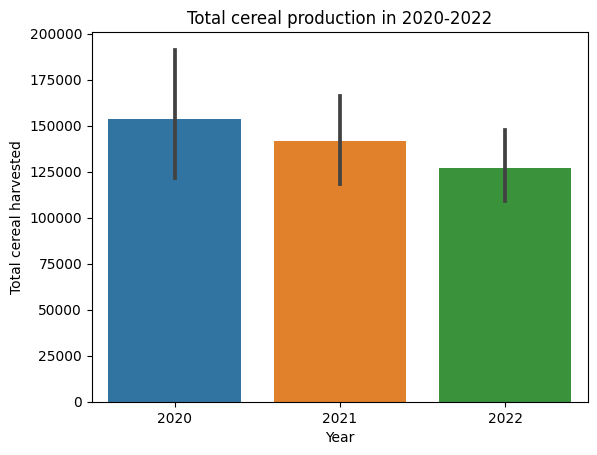

In [60]:

sns.barplot(x= 'Year', y= 'Value',data = cereals_harvested)
plt.title('Total cereal production in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total cereal harvested')
plt.show()



## Cereal production by Cities 

In [37]:
cereals_harvested_region = cereals_harvested.groupby(by = cereals_harvested.City)['Value','City'].sum().reset_index().sort_values(by = 'Value', ascending = False).head(10)
cereals_harvested_region

City     Value
93    Torino  23124980
32   Ferrara  23028082
34    Foggia  21307453
65     Pavia  19838758
29     Cuneo  19837083
51   Mantova  18620664
82    Rovigo  18543541
62    Padova  17583106
100  Venezia  17037702
14   Bologna  16209589

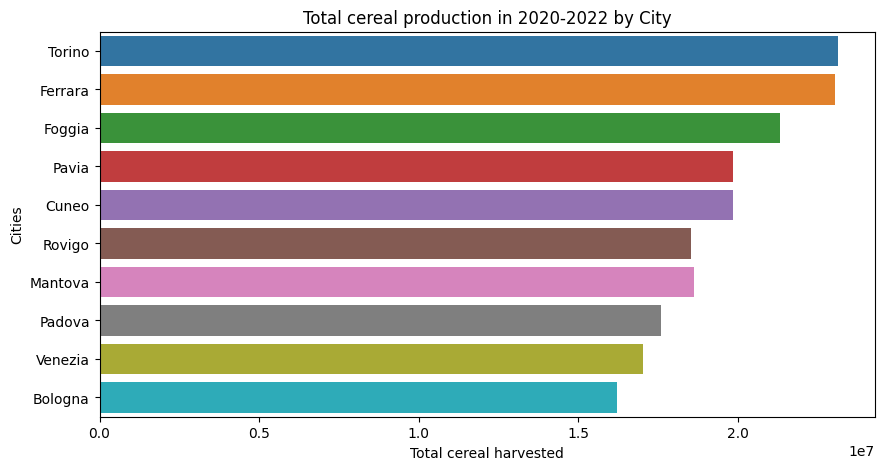

In [59]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_harvested_region['Value'],y= cereals_region['City'], orient='h');
plt.title('Total cereal production in 2020-2022 by City')
plt.xlabel('Total cereal harvested')
plt.ylabel('Cities')
plt.show()

## Italy geographic areas is organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## The most produced cereals 2020-2022

In [41]:
print(cereals_harvested.Type_crop.max())
print(cereals_harvested.Type_crop.value_counts())
print(cereals_harvested.Type_crop.nunique())



winter cereal mixtures (maslin)
barley                                                             300
oats                                                               290
durum wheat                                                        286
common wheat                                                       284
grain maize                                                        284
broad bean                                                         241
chick-peas                                                         235
other cereals                                                      226
dried kidney bean                                                  221
oats and spring cereal mixtures (mixed grain other than maslin)    195
protein pea                                                        193
winter barley                                                      187
common winter wheat and spelt                                      174
lentil                                       

Dataset shows there are 24 different types of cereals cultivated in Italy. The top five most produced crops are Wheat, Barley, Maize, Beans and Oats. 

In [42]:
cereals_harvested.describe()

Year         Value
count  4042.000000  4.042000e+03
mean   2021.082880  1.397498e+05
std       0.788942  4.759124e+05
min    2020.000000  0.000000e+00
25%    2020.000000  7.170000e+02
50%    2021.000000  5.000000e+03
75%    2022.000000  6.300000e+04
max    2022.000000  7.125000e+06

<AxesSubplot: >

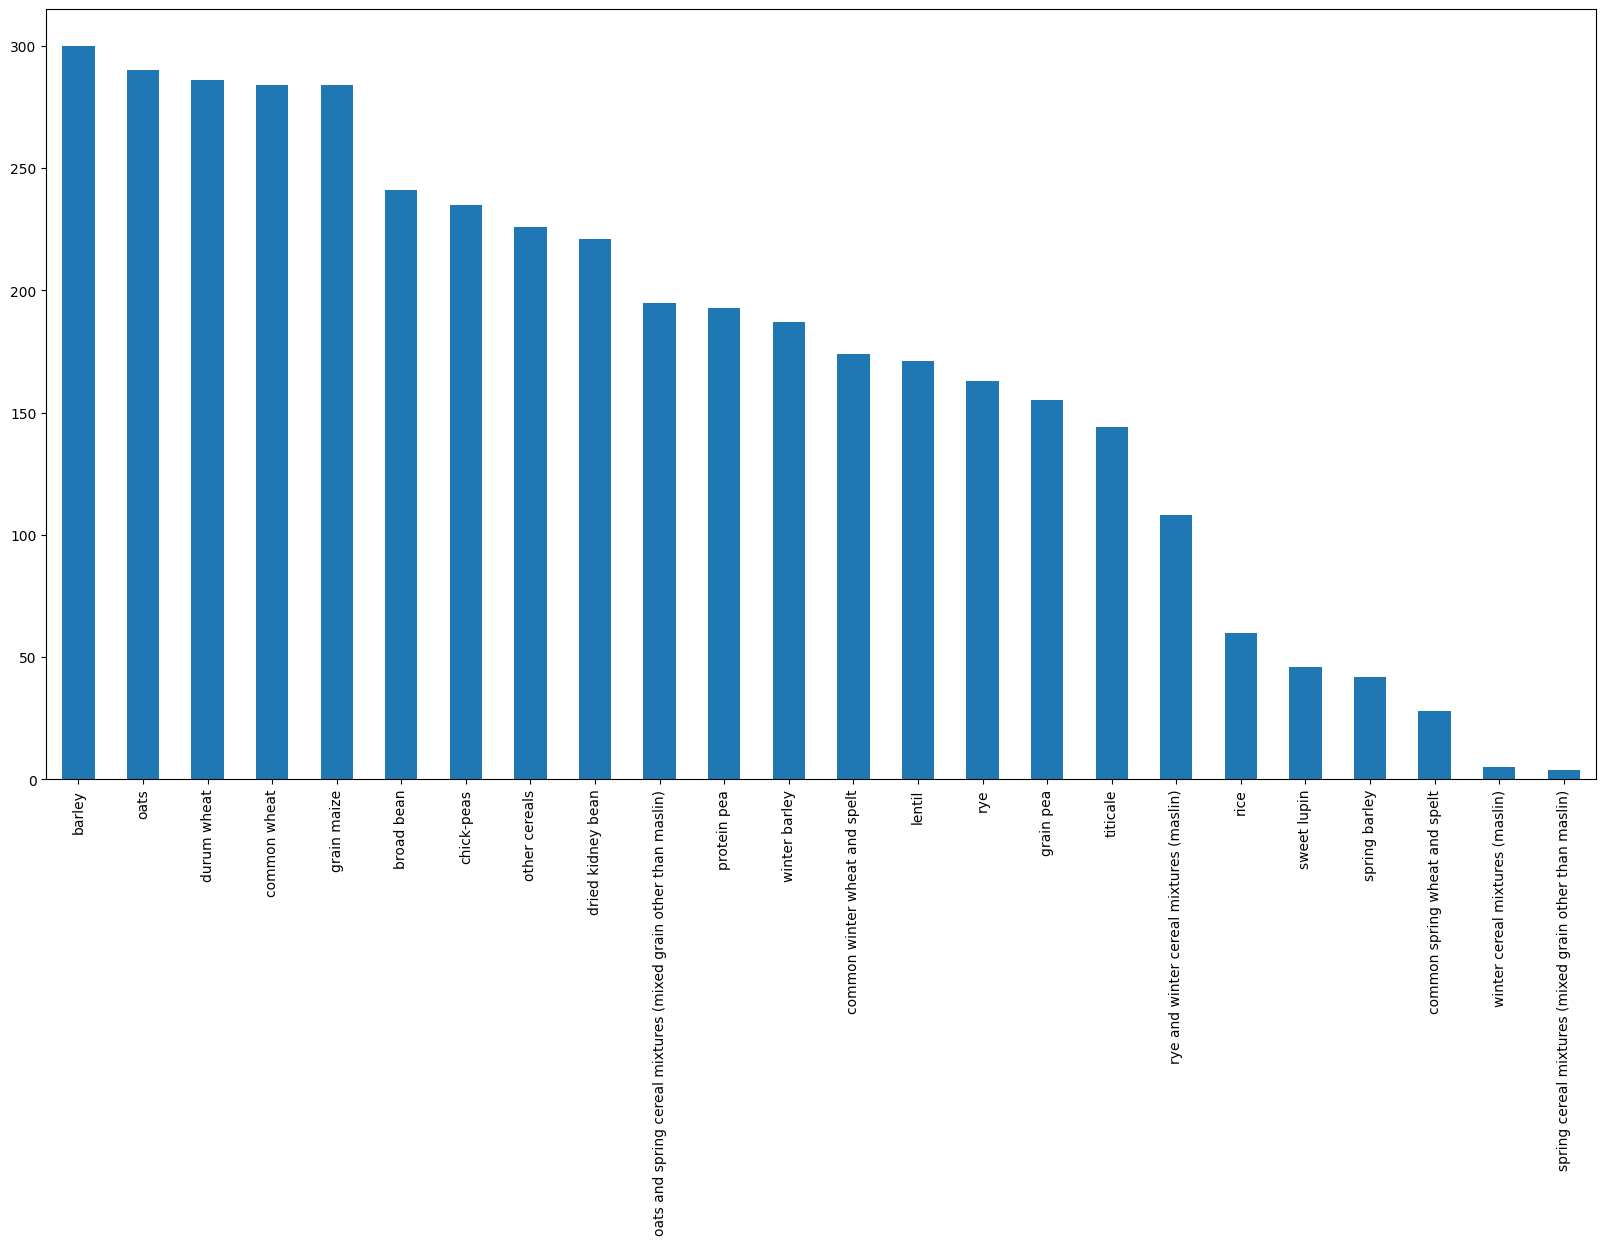

In [43]:
plt.figure(figsize=(20,10))
cereals_harvested ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [44]:
cereals_top10 = cereals_harvested.apply(lambda row: row[cereals_harvested['Type_crop'].isin(['winter cereal mixtures (maslin)','dried kidney bean','barley','oats', 
                                         'durum wheat','common wheat', 'grain maize', 'chick-peas',
                                                   'broad bean', 'rice'])])

cereals_top10.head()

City                         Data_type     Type_crop  Year   Value
6     Torino  harvested production - quintals   common wheat  2020  844910
7     Torino  harvested production - quintals   common wheat  2021  925705
8     Torino  harvested production - quintals   common wheat  2022  836750
15  Vercelli  harvested production - quintals   common wheat  2020   64250
16  Vercelli  harvested production - quintals   common wheat  2021   74550

## Stats

In [45]:
cereals_top10.describe().astype(int)

Year    Value
count  2206     2206
mean   2020   212859
std       0   611441
min    2020        0
25%    2020     1236
50%    2021    14150
75%    2022   120000
max    2022  7125000

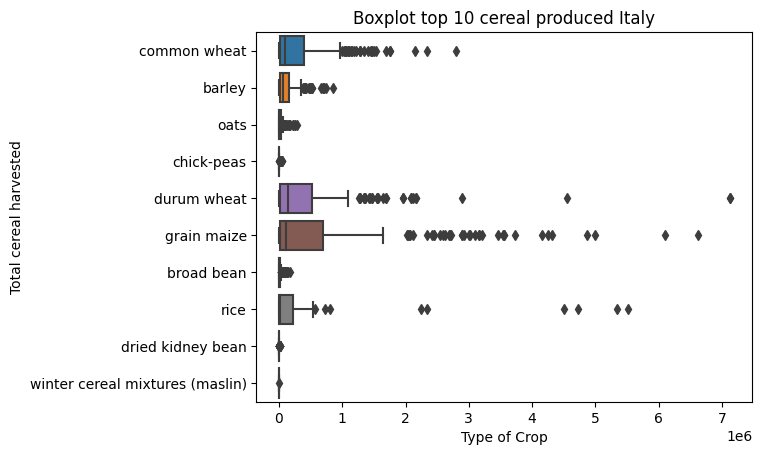

In [61]:

sns.boxplot(y='Type_crop',x='Value',data=cereals_top10) 
plt.title('Boxplot top 10 cereal produced Italy')
plt.xlabel('Type of Crop')
plt.ylabel('Total cereal harvested')
plt.show()


## Vizualization of ten type cereal produced in Italy in the period of 2020-2022 

<AxesSubplot: title={'center': 'Common wheat 2020-2022'}, xlabel='Year'>

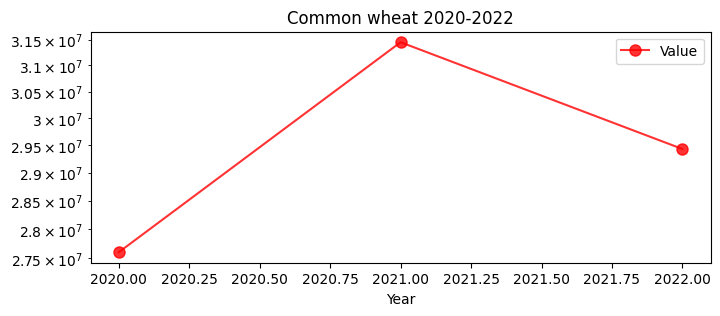

In [62]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='common wheat'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                     title = 'Common wheat 2020-2022')


<AxesSubplot: title={'center': 'Barley 2020-2022'}, xlabel='Year'>

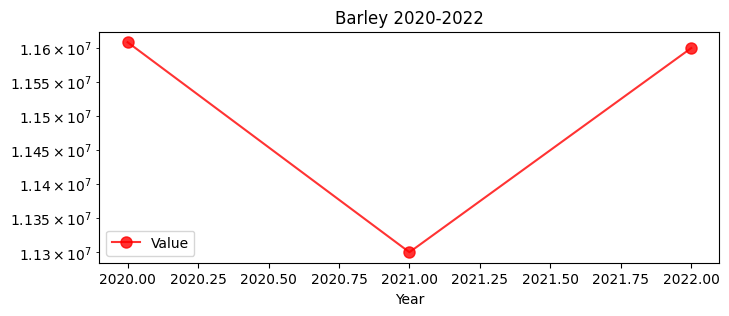

In [63]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='barley'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Barley 2020-2022')

<AxesSubplot: title={'center': 'Winter cereal mixtures 2020-2022'}, xlabel='Year'>

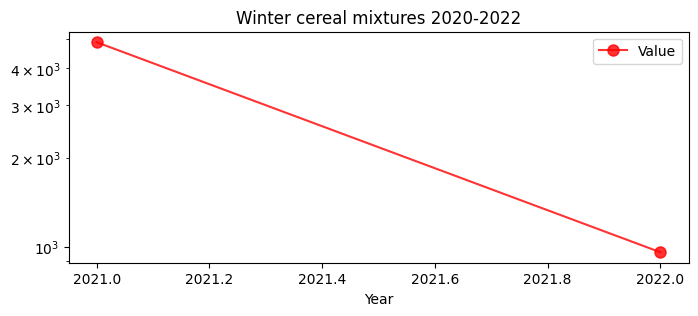

In [64]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='winter cereal mixtures (maslin)'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Winter cereal mixtures 2020-2022')

<AxesSubplot: title={'center': 'Dried kidney bean 2020-2022'}, xlabel='Year'>

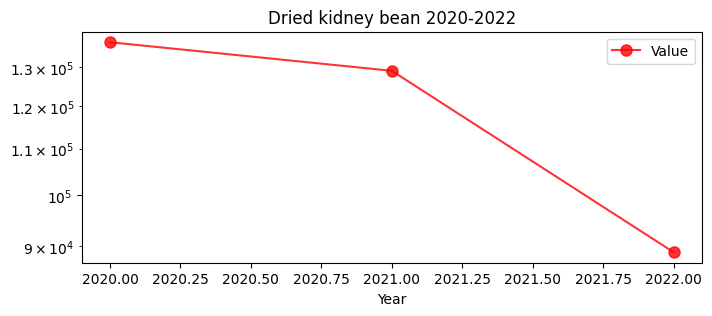

In [65]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='dried kidney bean'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Dried kidney bean 2020-2022')

<AxesSubplot: title={'center': 'Oats 2020-2022'}, xlabel='Year'>

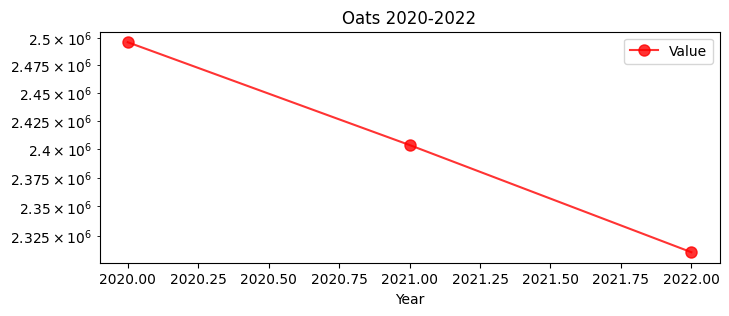

In [66]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='oats'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Oats 2020-2022')

<AxesSubplot: title={'center': 'Durum wheat 2020-2022'}, xlabel='Year'>

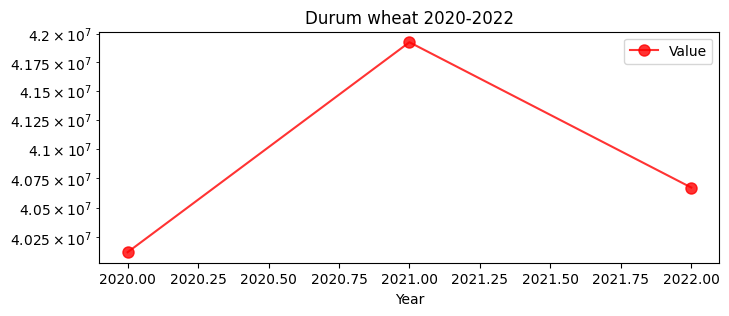

In [67]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='durum wheat'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Durum wheat 2020-2022')

<AxesSubplot: title={'center': 'Grain maize 2020-2022'}, xlabel='Year'>

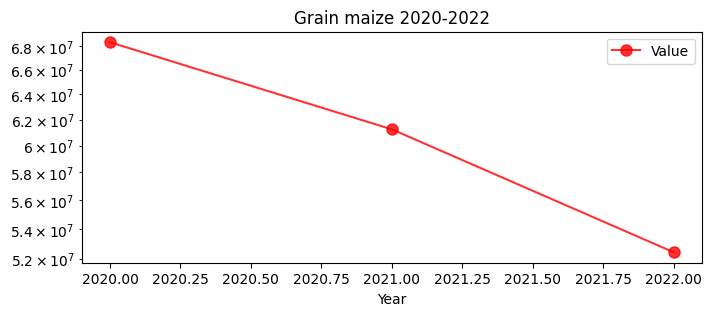

In [69]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='grain maize'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Grain maize 2020-2022')

<AxesSubplot: title={'center': 'Chick-peas 2020-2022'}, xlabel='Year'>

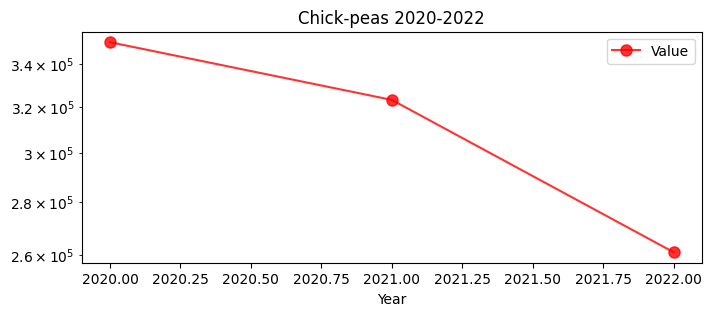

In [70]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='chick-peas'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Chick-peas 2020-2022')

<AxesSubplot: title={'center': 'Broad bean 2020-2022'}, xlabel='Year'>

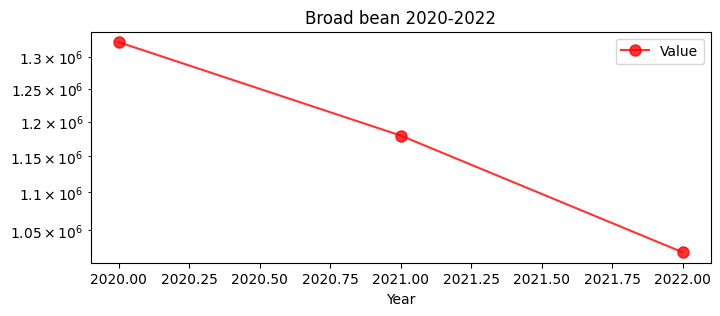

In [71]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)
y='broad bean'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Broad bean 2020-2022')

* Rice is not in the top crop production 
but it is an important crop , therefore I have included for further discussion in the group.  

<AxesSubplot: title={'center': 'Rice 2020-2022'}, xlabel='Year'>

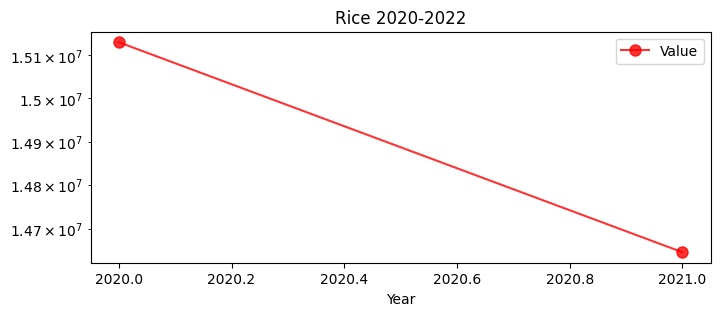

In [72]:

cereals_plot = cereals_top10[['Type_crop','Year', 'Value']]
cereals_plot['Year'] = cereals_plot['Year'].astype(int)

y='rice'
cereals_plot = cereals_plot.groupby('Type_crop').get_group(y)
cereals_plot = cereals_plot.groupby('Year')[['Value']].sum()

cereals_plot.plot(figsize=(8,3), logy=True, color=['red'], 
                               linestyle='solid', marker='o', alpha=0.8, markersize=8,
                  title = 'Rice 2020-2022')

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576